<a href="https://colab.research.google.com/github/manidumre/Master_Thesis/blob/main/CNN_3200_Real%2BGen_From_Model1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import os
import csv
import torch
import torchvision
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
from __future__ import print_function
#%matplotlib inline
import argparse
import random
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from torchvision.utils import save_image
import cv2
import glob
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
!pip install jovian opendatasets --upgrade --quiet
!pip install -q kaggle
import urllib.request
import opendatasets as od
from torchvision.utils import make_grid
%matplotlib inline
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
import shutil
import torch.nn.functional as F
# Authenticate and create the PyDrive client
gauth = GoogleAuth()
drive = GoogleDrive(gauth)
from torchvision.transforms import ToTensor
from skimage.metrics import structural_similarity as ssim
from torchvision.models import inception_v3
from scipy.linalg import sqrtm
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import warnings
warnings.filterwarnings("ignore")

In [ ]:
workers = 4
batch_size = 64
image_size = 64
image_channels = 3
num_classes = 3
nc = 3
nz = 100
ngf = 64
ndf = 64
lr = 0.0001
beta1 = 0.5
ngpu = 1
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
num_epochs = 50
opt_func = torch.optim.Adam

In [ ]:
import opendatasets as od
!pip install opendatasets --upgrade --quiet
dataset_url = 'https://www.kaggle.com/datasets/manidumre/balanced-dataset-by-model1-3270'
!cp -r "/content/drive/MyDrive/Mani Thesis/Code/kaggle.json" "/content"
od.download(dataset_url,force=True)

In [ ]:
import opendatasets as od
!pip install opendatasets --upgrade --quiet
dataset_url = 'https://www.kaggle.com/datasets/manidumre/manithesis'
!cp -r "/content/drive/MyDrive/Mani Thesis/Code/kaggle.json" "/content"
od.download(dataset_url)

100%|██████████| 3.46G/3.46G [03:29<00:00, 17.7MB/s]


In [ ]:
data_dir = '/content/balanced-dataset-by-model1-3270/Balanced_Dataset_by_Model1_3270/Curated X-Ray Dataset'
print(os.listdir(data_dir))

['COVID19', 'PNEUMONIA', 'NORMAL']


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# import shutil
# shutil.rmtree('/content/balanced-dataset-by-model1-3270/Balanced_Dataset_by_Model1_3270/Curated X-Ray Dataset/test')
# shutil.rmtree('/content/balanced-dataset-by-model1-3270/Balanced_Dataset_by_Model1_3270/Curated X-Ray Dataset/train')
# shutil.rmtree('/content/balanced-dataset-by-model1-3270/Balanced_Dataset_by_Model1_3270/Curated X-Ray Dataset/val')

###Split dataset into training testing and validation

In [ ]:
import os
import shutil
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms as T
from torch.utils.data import DataLoader, random_split

# Define the paths
dataset_path = '/content/balanced-dataset-by-model1-3270/Balanced_Dataset_by_Model1_3270/Curated X-Ray Dataset'
train_folder = os.path.join(dataset_path, 'train')
val_folder = os.path.join(dataset_path, 'val')
test_folder = os.path.join(dataset_path, 'test')

# Define the transformations
image_size = 64  # Set your desired image size
stats = ((0.5,), (0.5,))  # Set your desired normalization values
transform = T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)
])

# Load the dataset
dataset = ImageFolder(dataset_path, transform=transform)

# Define the sizes for training, validation, and test sets
total_size = len(dataset)
train_size = int(0.6 * total_size)  # 60% for training
val_size = int(0.1 * total_size)  # 20% for validation
test_size = total_size - train_size - val_size  # Remaining 20% for testing

# Split the dataset into train, validation, and test sets
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size,test_size ])

# Create data loaders
batch_size = 64  # Set your desired batch size
num_workers = 4  # Set the number of workers for data loading

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers, pin_memory=True)

# Move the images to their respective subfolders
def move_images_to_folder(dataset, folder):
    os.makedirs(os.path.join(folder, 'COVID19'), exist_ok=True)
    os.makedirs(os.path.join(folder, 'NORMAL'), exist_ok=True)
    os.makedirs(os.path.join(folder, 'PNEUMONIA'), exist_ok=True)

    for idx in dataset.indices:
        image_path, label = dataset.dataset.samples[idx]
        image_name = os.path.basename(image_path)

        if label == 0:  # COVID19
            target_path = os.path.join(folder, 'COVID19', image_name)
        elif label == 1:  # NORMAL
            target_path = os.path.join(folder, 'NORMAL', image_name)
        else:  # PNEUMONIA
            target_path = os.path.join(folder, 'PNEUMONIA', image_name)

        shutil.move(image_path, target_path)

# Create the subfolders if they don't exist
os.makedirs(train_folder, exist_ok=True)
os.makedirs(val_folder, exist_ok=True)
os.makedirs(test_folder, exist_ok=True)

# Move images to the respective subfolders
move_images_to_folder(train_dataset, train_folder)
move_images_to_folder(val_dataset, val_folder)
move_images_to_folder(test_dataset, test_folder)

print("Train dataset size:", len(train_dataset))
print("Validation dataset size:", len(val_dataset))
print("Test dataset size:", len(test_dataset))

Train dataset size: 5886
Validation dataset size: 981
Test dataset size: 2943


In [ ]:
import shutil
shutil.rmtree('/content/balanced-dataset-by-model1-3270/Balanced_Dataset_by_Model1_3270/Curated X-Ray Dataset/COVID19')
shutil.rmtree('/content/balanced-dataset-by-model1-3270/Balanced_Dataset_by_Model1_3270/Curated X-Ray Dataset/NORMAL')
shutil.rmtree('/content/balanced-dataset-by-model1-3270/Balanced_Dataset_by_Model1_3270/Curated X-Ray Dataset/PNEUMONIA')

## Loader

In [ ]:
import os
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms as T
from torch.utils.data import DataLoader

# Define the paths
train_folder = '/content/balanced-dataset-by-model1-3270/Balanced_Dataset_by_Model1_3270/Curated X-Ray Dataset/train'
test_folder = '/content/balanced-dataset-by-model1-3270/Balanced_Dataset_by_Model1_3270/Curated X-Ray Dataset/test'
val_folder = '/content/balanced-dataset-by-model1-3270/Balanced_Dataset_by_Model1_3270/Curated X-Ray Dataset/val'

# Define the transformations
image_size = 64  # Set your desired image size
stats = ((0.5,), (0.5,))  # Set your desired normalization values
transform = T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)
])

# Create the dataset objects
train_dataset = ImageFolder(train_folder, transform=transform)
test_dataset = ImageFolder(test_folder, transform=transform)
val_dataset = ImageFolder(val_folder, transform=transform)

# Define batch size and number of workers
batch_size = 64  # Set your desired batch size
num_workers = 4  # Set the number of workers for data loading

# Create the data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers, pin_memory=True)


## For Original Dataset

## Split into training, testing and validation

In [ ]:
# shutil.rmtree('/content/manithesis/Curated X-Ray Dataset/test')

In [ ]:
import os
import shutil
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms as T
from torch.utils.data import DataLoader, random_split

# Define the paths
dataset_path = '/content/manithesis/Curated X-Ray Dataset'
train_folder = os.path.join(dataset_path, 'train')
val_folder = os.path.join(dataset_path, 'val')
test_folder = os.path.join(dataset_path, 'test')

# Define the transformations
image_size = 64  # Set your desired image size
stats = ((0.5,), (0.5,))  # Set your desired normalization values
transform = T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)
])

# Load the dataset
dataset = ImageFolder(dataset_path, transform=transform)

# Define the sizes for training, validation, and test sets
total_size = len(dataset)
train_size = int(0.8 * total_size)  # 60% for training
# val_size = int(0.2 * total_size)  # 20% for validation
test_size = total_size - train_size  # Remaining 20% for testing

# Split the dataset into train, validation, and test sets
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create data loaders
batch_size = 64  # Set your desired batch size
num_workers = 4  # Set the number of workers for data loading

# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers, pin_memory=True)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers, pin_memory=True)

# Move the images to their respective subfolders
def move_images_to_folder(dataset, folder):
    os.makedirs(os.path.join(folder, 'COVID19'), exist_ok=True)
    os.makedirs(os.path.join(folder, 'NORMAL'), exist_ok=True)
    os.makedirs(os.path.join(folder, 'PNEUMONIA'), exist_ok=True)

    for idx in dataset.indices:
        image_path, label = dataset.dataset.samples[idx]
        image_name = os.path.basename(image_path)

        if label == 0:  # COVID19
            target_path = os.path.join(folder, 'COVID19', image_name)
        elif label == 1:  # NORMAL
            target_path = os.path.join(folder, 'NORMAL', image_name)
        else:  # PNEUMONIA
            target_path = os.path.join(folder, 'PNEUMONIA', image_name)

        shutil.move(image_path, target_path)

# Create the subfolders if they don't exist
os.makedirs(train_folder, exist_ok=True)
# os.makedirs(val_folder, exist_ok=True)
os.makedirs(test_folder, exist_ok=True)

# Move images to the respective subfolders
move_images_to_folder(train_dataset, train_folder)
# move_images_to_folder(val_dataset, val_folder)
move_images_to_folder(test_dataset, test_folder)

print("Train dataset size:", len(train_dataset))
# print("Validation dataset size:", len(val_dataset))
print("Test dataset size:", len(test_dataset))

Train dataset size: 6409
Test dataset size: 1603


In [ ]:
import shutil
shutil.rmtree('/content/manithesis/Curated X-Ray Dataset/COVID19')
shutil.rmtree('/content/manithesis/Curated X-Ray Dataset/NORMAL')
shutil.rmtree('/content/manithesis/Curated X-Ray Dataset/PNEUMONIA')

## Test Loader

In [ ]:
import os
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms as T
from torch.utils.data import DataLoader

# Define the paths
# train_folder = '/content/manithesis/Curated X-Ray Dataset/train'
test_folder = '/content/manithesis/Curated X-Ray Dataset/test'
# val_folder = '/content/manithesis/Curated X-Ray Dataset/val'

# Define the transformations
image_size = 64  # Set your desired image size
stats = ((0.5,), (0.5,))  # Set your desired normalization values
transform = T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)
])

# Create the dataset objects
# train_dataset = ImageFolder(train_folder, transform=transform)
test_dataset = ImageFolder(test_folder, transform=transform)
# val_dataset = ImageFolder(val_folder, transform=transform)

# Define batch size and number of workers
batch_size = 64  # Set your desired batch size
num_workers = 4  # Set the number of workers for data loading

# Create the data loaders
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers, pin_memory=True)
# val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers, pin_memory=True)

In [ ]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

In [ ]:
def apply_kernel(image, kernel):
    ri, ci = image.shape       # image dimensions
    rk, ck = kernel.shape      # kernel dimensions
    ro, co = ri-rk+1, ci-ck+1  # output dimensions
    output = torch.zeros([ro, co])
    for i in range(ro):
        for j in range(co):
            output[i,j] = torch.sum(image[i:i+rk,j:j+ck] * kernel)
    return output

In [ ]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        acc = accuracy(out, labels)         # Calculate accuracy
        return {'train_loss': loss, 'train_acc': acc}

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()*100}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, train_acc: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['train_loss'], result['train_acc'], result['val_loss'], result['val_acc']))

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


In [ ]:
class CovidCnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(image_channels, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Flatten(),
            nn.Linear(256 * (image_size//8) * (image_size//8), 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes))

    def forward(self, xb):
        return self.network(xb)

In [ ]:
model = CovidCnnModel()
model

CovidCnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=16384, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_featu

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_loader, device)
val_dl = DeviceDataLoader(val_loader, device)
to_device(model, device);

In [ ]:
def save_model(epoch,model):
  torch.save(model.state_dict(), '/content/drive/MyDrive/Mani Thesis/Model_Save/CNN/DCGAN/Dataset1/CNN_3200_Real+Gen_From_Model1/CNN_3200_Real+Gen_From_Model1_Image_Size:' + str(image_size) + str('_Epoch:')+ str(epoch) +'.pth')

def save_history(epoch, history, filename):
    filename= '/content/drive/MyDrive/Mani Thesis/Model_Save/CNN/DCGAN/Dataset1/CNN_3200_Real+Gen_From_Model1/CNN_3200_Real+Gen_From_Model1_History_'+str(image_size) + str('_Epoch:')+ str(epoch) +'.csv'
    with open(filename, 'w', newline='') as csvfile:
        fieldnames = history[0].keys()
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        writer.writerows(history)

In [ ]:
def load_history(filename):
    history = []
    with open(filename, 'r') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            history.append({k: float(row[k]) for k in row.keys()})
    return history

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    criterion = nn.CrossEntropyLoss()
    start_epoch = 0
    epochs=101
    for epoch in range(start_epoch, epochs + 1):
    #for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        train_correct = 0
        total_train = 0

        # Validation phase
        for batch in train_loader:
          images, labels = batch

          outputs = model(images)
          loss = criterion(outputs, labels)
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          train_losses.append(loss.item())
          _, predicted = torch.max(outputs.data, 1)
          total_train += labels.size(0)
          train_correct += (predicted == labels).sum().item()
          train_acc = 100 * train_correct / total_train
          train_loss = torch.tensor(train_losses).mean().item()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = train_loss
        result['train_acc'] = train_acc
        model.epoch_end(epoch, result)
        history.append(result)

        if (epoch % 5 == 0):
            save_model(epoch, model)
            save_history(epoch, history, filename='/content/drive/MyDrive/Mani Thesis/Model_Save/CNN/DCGAN/Dataset1/CNN_3200_Real+Gen_From_Model1/CNN_3200_Real+Gen_From_Model1_History_'+str(image_size) + str('_Epoch:')+ str(epoch) +'.csv')

    return history


In [ ]:
model = to_device(CovidCnnModel(), device)

In [ ]:
evaluate(model, val_dl)

{'val_loss': 1.0993510484695435, 'val_acc': 33.10546875}

In [ ]:
num_epochs = 1000
optimizer = optim.Adam
history = fit(num_epochs, lr, model, train_dl, val_dl, optimizer)

Epoch [0], train_loss: 0.5329, train_acc: 76.1340, val_loss: 0.3036, val_acc: 89.7657
Epoch [1], train_loss: 0.2262, train_acc: 92.2783, val_loss: 0.2449, val_acc: 91.2706
Epoch [2], train_loss: 0.1840, train_acc: 93.9093, val_loss: 0.2356, val_acc: 91.2010
Epoch [3], train_loss: 0.1589, train_acc: 94.4827, val_loss: 0.2238, val_acc: 91.3450
Epoch [4], train_loss: 0.1336, train_acc: 95.3746, val_loss: 0.1537, val_acc: 94.2516
Epoch [5], train_loss: 0.1066, train_acc: 96.2156, val_loss: 0.1339, val_acc: 94.9333
Epoch [6], train_loss: 0.0954, train_acc: 96.6233, val_loss: 0.1527, val_acc: 94.1004
Epoch [7], train_loss: 0.0856, train_acc: 96.9164, val_loss: 0.1335, val_acc: 94.8325
Epoch [8], train_loss: 0.0720, train_acc: 97.5280, val_loss: 0.1406, val_acc: 94.5301
Epoch [9], train_loss: 0.0583, train_acc: 97.8976, val_loss: 0.1054, val_acc: 96.2702
Epoch [10], train_loss: 0.0517, train_acc: 98.1906, val_loss: 0.1088, val_acc: 96.9494
Epoch [11], train_loss: 0.0516, train_acc: 98.1779, v

KeyboardInterrupt: ignored

In [ ]:
epoch=20

In [ ]:
save_model(epoch, model)
save_history(epoch, history, filename='/content/drive/MyDrive/Mani Thesis/Model_Save/CNN/DCGAN/Dataset1/CNN_3200_Real+Gen_From_Model1/CNN_3200_Real+Gen_From_Model1_History_'+str(image_size) + str('_Epoch:')+ str(epoch) +'.csv')


In [ ]:
image_size =64
end_epoch=20
filename= f'/content/drive/MyDrive/Mani Thesis/Model_Save/CNN/DCGAN/Dataset1/CNN_3200_Real+Gen_From_Model1/CNN_3200_Real+Gen_From_Model1_History_'+str(image_size) + str('_Epoch:')+ str(end_epoch) +'.csv'
history= load_history(filename)

In [ ]:
num_epochs=36
model.load_state_dict(torch.load('/content/drive/MyDrive/Mani Thesis/Model_Save/CNN/DCGAN/Dataset1/CNN_3200_Real+Gen_From_Model1/CNN_3200_Real+Gen_From_Model1_Image_Size:' + str(image_size) + str('_Epoch:')+ str(num_epochs) +'.pth'))

<All keys matched successfully>

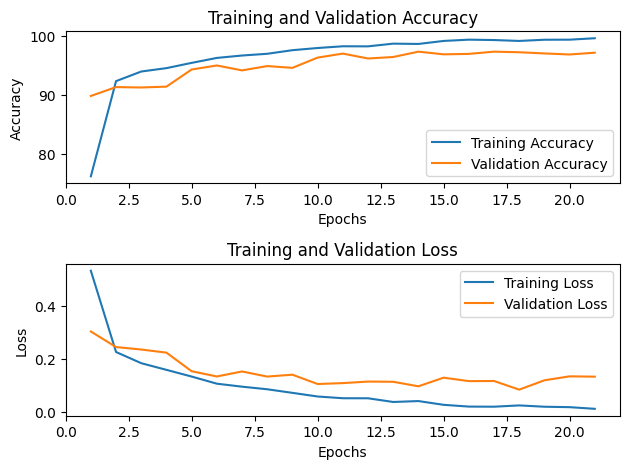

In [ ]:
def plot_loss(history):
    epochs = range(1, len(history) + 1)
    train_losses = [h['train_loss'] for h in history]
    val_losses = [h['val_loss'] for h in history]
    train_accs = [h['train_acc'] for h in history]
    val_accs = [h['val_acc'] for h in history]

    plt.subplot(2, 1, 1)
    plt.plot(epochs, train_accs, label='Training Accuracy')
    plt.plot(epochs, val_accs, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/Mani Thesis/Results_Graphs/CNN/DCGAN/Dataset1/CNN_3200_Real+Gen_From_Model1/'+ str('CNN_3200_Real+Gen_From_Model1_Training Accuracy_Validation Accuracy and loss vs. No. of epochs:  Image_Size: ')+str(image_size)+str(' Epoch_No:')+(str(num_epochs)+'.png'))
    plt.show()
plot_loss(history)

In [ ]:
print(len(history))

41


Maximum Training Loss: 0.5328873991966248
Maximum Validation Loss: 0.30360156297683716
Maximum Training Accuracy: 99.55402650356778
Maximum Validation Accuracy: 97.27822542190552


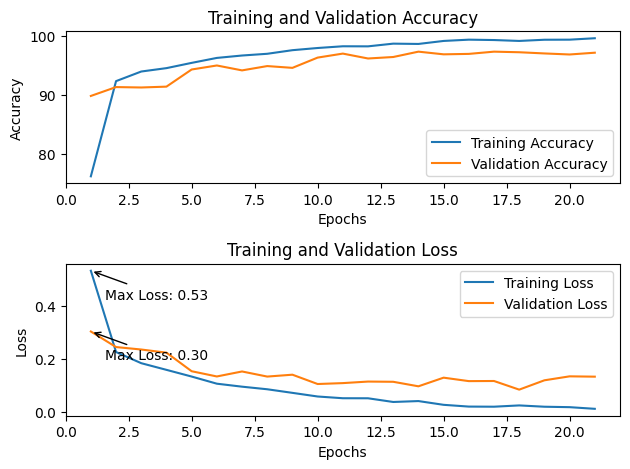

In [ ]:
import matplotlib.pyplot as plt
def plot_loss(history):
    epochs = range(1, len(history) + 1)
    train_losses = [h['train_loss'] for h in history]
    val_losses = [h['val_loss'] for h in history]
    train_accs = [h['train_acc'] for h in history]
    val_accs = [h['val_acc'] for h in history]

    plt.subplot(2, 1, 1)
    plt.plot(epochs, train_accs, label='Training Accuracy')
    plt.plot(epochs, val_accs, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')

    # Find the maximum values
    max_train_loss, max_val_loss, max_train_acc, max_val_acc = find_maximum(history)

    # Annotate the maximum values on the graph
    plt.annotate(f'Max Loss: {max_train_loss:.2f}', xy=(epochs[train_losses.index(max_train_loss)], max_train_loss), xytext=(10, -20), textcoords='offset points', arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))
    plt.annotate(f'Max Loss: {max_val_loss:.2f}', xy=(epochs[val_losses.index(max_val_loss)], max_val_loss), xytext=(10, -20), textcoords='offset points', arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))
    plt.annotate(f'Max Acc: {max_train_acc:.2f}', xy=(epochs[train_accs.index(max_train_acc)], max_train_acc), xytext=(10, 10), textcoords='offset points', arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))
    plt.annotate(f'Max Acc: {max_val_acc:.2f}', xy=(epochs[val_accs.index(max_val_acc)], max_val_acc), xytext=(10, 10), textcoords='offset points', arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))



    plt.legend()
    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/Mani Thesis/Results_Graphs/CNN/DCGAN/Dataset1/CNN_3200_Real+Gen_From_Model1'+ str('CNN_3200_Real+Gen_From_Model1_Training Accuracy_Validation Accuracy and loss vs. No. of epochs:  Image_Size: ')+str(image_size)+str(' Epoch_No:')+(str(num_epochs)+'.png'))
    plt.show()

def find_maximum(history):
    train_losses = [h['train_loss'] for h in history]
    val_losses = [h['val_loss'] for h in history]
    train_accs = [h['train_acc'] for h in history]
    val_accs = [h['val_acc'] for h in history]

    max_train_loss = max(train_losses)
    max_val_loss = max(val_losses)
    max_train_acc = max(train_accs)
    max_val_acc = max(val_accs)

    return max_train_loss, max_val_loss, max_train_acc, max_val_acc

# Assuming 'history' contains the data
max_train_loss, max_val_loss, max_train_acc, max_val_acc = find_maximum(history)

print("Maximum Training Loss:", max_train_loss)
print("Maximum Validation Loss:", max_val_loss)
print("Maximum Training Accuracy:", max_train_acc)
print("Maximum Validation Accuracy:", max_val_acc)

# Plot the loss graph with annotations for maximum values
plot_loss(history)

Maximum Training Loss: 0.5328873991966248
Maximum Validation Loss: 0.30360156297683716
Maximum Training Accuracy: 99.55402650356778
Maximum Validation Accuracy: 97.27822542190552


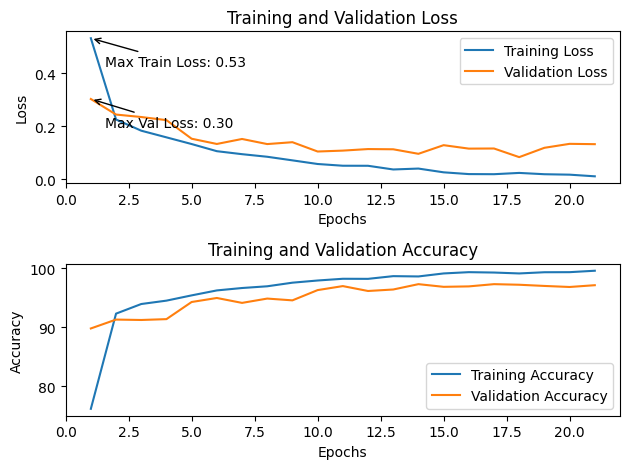

In [ ]:
import matplotlib.pyplot as plt

def plot_loss(history):
    epochs = range(1, len(history) + 1)
    train_losses = [h['train_loss'] for h in history]
    val_losses = [h['val_loss'] for h in history]
    train_accs = [h['train_acc'] for h in history]
    val_accs = [h['val_acc'] for h in history]

    plt.subplot(2, 1, 2)
    plt.plot(epochs, train_accs, label='Training Accuracy')
    plt.plot(epochs, val_accs, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.subplot(2, 1, 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')

    # Find the maximum values
    max_train_loss, max_val_loss, max_train_acc, max_val_acc = find_maximum(history)

    # Annotate the maximum values on the graph
    plt.annotate(f'Max Train Loss: {max_train_loss:.2f}', xy=(epochs[train_losses.index(max_train_loss)], max_train_loss), xytext=(10, -20), textcoords='offset points', arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))
    plt.annotate(f'Max Val Loss: {max_val_loss:.2f}', xy=(epochs[val_losses.index(max_val_loss)], max_val_loss), xytext=(10, -20), textcoords='offset points', arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))
    plt.annotate(f'Max Train Acc: {max_train_acc:.2f}', xy=(epochs[train_accs.index(max_train_acc)], max_train_acc), xytext=(10, 10), textcoords='offset points', arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))
    plt.annotate(f'Max Val Acc: {max_val_acc:.2f}', xy=(epochs[val_accs.index(max_val_acc)], max_val_acc), xytext=(10, 10), textcoords='offset points', arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))

    # Add maximum values in legend
    legend_labels = plt.legend().get_texts()
    legend_labels = [label.get_text() for label in legend_labels]
    legend_labels.extend([
        f'Max Train Loss: {max_train_loss:.2f}',
        f'Max Val Loss: {max_val_loss:.2f}',
        f'Max Train Acc: {max_train_acc:.2f}',
        f'Max Val Acc: {max_val_acc:.2f}'
    ])
    plt.legend(legend_labels)

    plt.tight_layout()
    plt.show()

def find_maximum(history):
    train_losses = [h['train_loss'] for h in history]
    val_losses = [h['val_loss'] for h in history]
    train_accs = [h['train_acc'] for h in history]
    val_accs = [h['val_acc'] for h in history]

    max_train_loss = max(train_losses)
    max_val_loss = max(val_losses)
    max_train_acc = max(train_accs)
    max_val_acc = max(val_accs)

    return max_train_loss, max_val_loss, max_train_acc, max_val_acc

# Assuming 'history' contains the data
max_train_loss, max_val_loss, max_train_acc, max_val_acc = find_maximum(history)

print("Maximum Training Loss:", max_train_loss)
print("Maximum Validation Loss:", max_val_loss)
print("Maximum Training Accuracy:", max_train_acc)
print("Maximum Validation Accuracy:", max_val_acc)

# Plot the loss graph with annotations for maximum values
plot_loss(history)


In [ ]:
test_folder = '/content/manithesis/Curated X-Ray Dataset/train'
image_size = 64  # Set your desired image size
stats = ((0.5,), (0.5,))  # Set your desired normalization values
transform = T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)
])


test_dataset = ImageFolder(test_folder, transform=transform)
batch_size = 64  # Set your desired batch size
num_workers = 4  # Set the number of workers for data loading
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers, pin_memory=True)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size*2), device)
result = evaluate(model.to(device), test_loader)

In [ ]:
result = evaluate(model.to(device), test_loader)
result

RuntimeError: ignored

Let's define a helper function `predict_image`, which returns the predicted label for a single image tensor.

In [ ]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

Label: COVID19 , Predicted: NORMAL


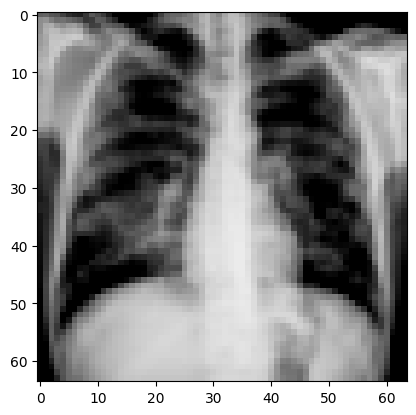

In [ ]:
img, label = test_dataset[0]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: NORMAL , Predicted: NORMAL


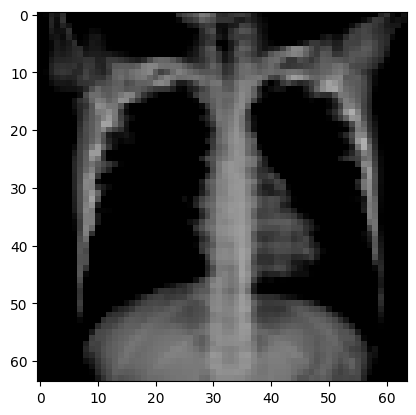

In [ ]:
img, label = test_dataset[1002]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: COVID19 , Predicted: NORMAL


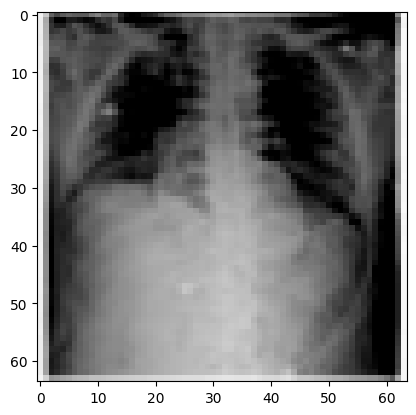

In [ ]:
img, label = test_dataset[12]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

###Confusion matrix


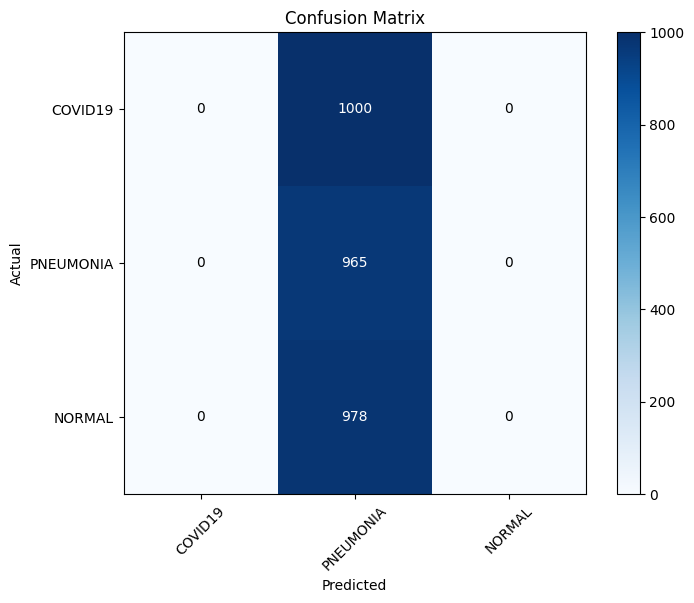

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import pandas as pd


def plot_confusion_matrix(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            # Convert labels and predicted values to numpy arrays
            predicted = predicted.cpu().numpy()
            labels = labels.cpu().numpy()

            y_pred.extend(predicted)
            y_true.extend(labels)

    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Calculate count of samples in each class
    class_counts = np.bincount(y_true, minlength=3)  # Assuming 3 classes

    # Plot confusion matrix
    classes = ['COVID19', 'PNEUMONIA', 'NORMAL']  # Specify the class labels in your dataset
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")

    # Add count labels to the confusion matrix plot
    thresh = cm.max() / 2
    for i in range(len(classes)):
        for j in range(len(classes)):
            plt.text(j, i, format(cm[i, j]), ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.show()
    plt.savefig('/content/drive/MyDrive/Mani Thesis/Results_Graphs/CNN/DCGAN/Dataset1/CNN_3200_Real+Gen_From_Model1'+ str('CNN_3200_Real+Gen_From_Model1_Confusion Matrix Epoch_No:  Image_Size: ')+str(image_size)+str(' Epoch_No:')+(str(num_epochs)+'.png'))


plot_confusion_matrix(model, test_loader)

# Evaluation on the test set
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    true_positives_covid = 0
    false_positives_covid = 0
    false_negatives_covid = 0
    true_positives_non_covid = 0
    false_positives_non_covid = 0
    false_negatives_non_covid = 0
    true_positives_normal = 0
    false_positives_normal = 0
    false_negatives_normal = 0

    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        # Accuracy
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # COVID-19 metrics
        true_positives_covid += ((predicted == labels) & (predicted == 0)).sum().item()
        false_positives_covid += ((predicted != labels) & (predicted == 0)).sum().item()
        false_negatives_covid += ((predicted != labels) & (predicted != 0)).sum().item()

        # Non-COVID metrics
        true_positives_non_covid += ((predicted == labels) & (predicted == 1)).sum().item()
        false_positives_non_covid += ((predicted != labels) & (predicted == 1)).sum().item()
        false_negatives_non_covid += ((predicted != labels) & (predicted != 1)).sum().item()

        # Normal metrics
        true_positives_normal += ((predicted == labels) & (predicted == 2)).sum().item()
        false_positives_normal += ((predicted != labels) & (predicted == 2)).sum().item()
        false_negatives_normal += ((predicted != labels) & (predicted != 2)).sum().item()

    accuracy = correct / total

    # COVID-19 metrics
    precision_covid = true_positives_covid / (true_positives_covid + false_positives_covid)
    recall_covid = true_positives_covid / (true_positives_covid + false_negatives_covid)
    f1_score_covid = 2 * ((precision_covid * recall_covid) / (precision_covid + recall_covid))

    # Non-COVID metrics
    precision_non_covid = true_positives_non_covid / (true_positives_non_covid + false_positives_non_covid)
    recall_non_covid = true_positives_non_covid / (true_positives_non_covid + false_negatives_non_covid)
    f1_score_non_covid = 2 * ((precision_non_covid * recall_non_covid) / (precision_non_covid + recall_non_covid))

    # Normal metrics
    precision_normal = true_positives_normal / (true_positives_normal + false_positives_normal)
    recall_normal = true_positives_normal / (true_positives_normal + false_negatives_normal)
    f1_score_normal = 2 * ((precision_normal * recall_normal) / (precision_normal + recall_normal))


    # Create a dictionary with the evaluation metrics
    metrics_dict = {
        "Metrics": ["Accuracy", "Precision", "Recall", "F1 Score"],
        "COVID19": [accuracy, precision_covid, recall_covid, f1_score_covid],
        "PNEUMONIA": [accuracy, precision_non_covid, recall_non_covid, f1_score_non_covid],
        "NORMAL": [accuracy, precision_normal, recall_normal, f1_score_normal]
    }

    # Create a DataFrame from the metrics dictionary
    metrics_df = pd.DataFrame(metrics_dict)

    # Set the "Metrics" column as the index
    metrics_df.set_index("Metrics", inplace=True)

    # Display the DataFrame
    print(metrics_df)

    import torch.optim as optim

    num_classes = 3
    true_positives = np.zeros(num_classes)
    false_positives = np.zeros(num_classes)
    true_negatives = np.zeros(num_classes)
    false_negatives = np.zeros(num_classes)

    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        for class_index in range(num_classes):
            true_positives[class_index] += ((predicted == class_index) & (labels == class_index)).sum().item()
            false_positives[class_index] += ((predicted == class_index) & (labels != class_index)).sum().item()
            true_negatives[class_index] += ((predicted != class_index) & (labels != class_index)).sum().item()
            false_negatives[class_index] += ((predicted != class_index) & (labels == class_index)).sum().item()

    specificity = true_negatives / (true_negatives + false_positives)

    for class_index in range(num_classes):
        print(f"Specificity (Class {class_index}): {specificity[class_index]:.4f}")


###ROC Curve

0.999950225478582
0.9997771977847094
0.9997555117238737


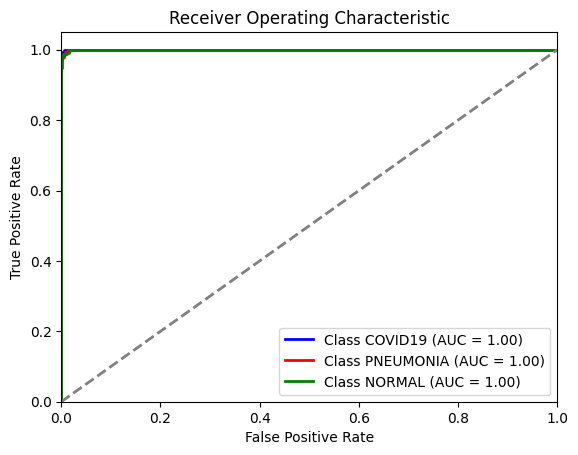

In [ ]:

# Evaluation on the test set
model.eval()
with torch.no_grad():
    # Store predicted probabilities and ground truth labels
    y_scores = []
    y_true = []

    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        probabilities = nn.Softmax(dim=1)(outputs)

        # Convert probabilities and labels to numpy arrays
        y_scores.extend(probabilities.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

    y_scores = np.array(y_scores)
    y_true = np.array(y_true)

    # Compute ROC curve and AUC for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for class_index in range(num_classes):
        fpr[class_index], tpr[class_index], _ = roc_curve(y_true == class_index, y_scores[:, class_index])
        roc_auc[class_index] = auc(fpr[class_index], tpr[class_index])
        print(roc_auc[class_index])

    # Plot ROC curve
    plt.figure()
    lw = 2
    colors = ['blue', 'red', 'green']
    class_labels = ['COVID19', 'PNEUMONIA', 'NORMAL']
    for class_index in range(num_classes):
        plt.plot(fpr[class_index], tpr[class_index], color=colors[class_index],
                 lw=lw, label=f'Class {class_labels[class_index]} (AUC = {roc_auc[class_index]:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.savefig('/content/drive/MyDrive/Mani Thesis/Results_Graphs/CNN/DCGAN/Dataset1/CNN_3200_Real+Gen_From_Model1'+ str('CNN_3200_Real+Gen_From_Model1_ROC_Curve_Epoch_No: Image_Size: ')+str(image_size)+str(' Epoch_No:')+(str(num_epochs)+'.png'))
    plt.show()

## To Store the values into Excel sheet

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import numpy as np
import pandas as pd
from torchvision.transforms import transforms
from torchvision.datasets import ImageFolder


# Check if a GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the image sizes, learning rates, batch sizes, and epochs to explore
image_sizes = [128]  # Different image sizes to explore
learning_rates = [0.001]  # Different learning rates to explore
batch_sizes = [32]  # Different batch sizes to explore
epochs = [100]  # Different number of epochs to explore

# Define a function to preprocess your dataset based on the specified image size
def preprocess_dataset(image_size):
    # Define the transformations to apply to the images
    transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),  # Resize the images
        transforms.ToTensor(),  # Convert the images to tensors
        transforms.Normalize((0.5,), (0.5,))  # Normalize the pixel values
    ])

    # Load the dataset and apply the transformations
    train_dataset = ImageFolder(data_dir+'/Train', transform=transform)
    test_dataset = ImageFolder(data_dir+'/Test', transform=transform)

    return train_dataset, test_dataset

# Define a function to train and evaluate the model for different configurations
def train_and_evaluate(image_size, learning_rate, batch_size, num_epochs):
    # Load and preprocess your dataset based on the specified image size
    train_dataset, test_dataset = preprocess_dataset(image_size)

    # Create data loaders for training and testing
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    #train_loader=train_dl

    # Create an instance of your CNN model and move it to the GPU
    model = CovidCnnModel().to(device)

    # Define the loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Train the model
    for epoch in range(num_epochs):
        model.train()
        for batch in train_loader:
                images, labels = batch[0].to(device), batch[1].to(device)  # Unpack the batch correctly

                optimizer.zero_grad()

                # Forward pass
                outputs = model(images)
                loss = criterion(outputs, labels)

                # Backward pass and optimization
                loss.backward()
                optimizer.step()

    # Evaluate the model


    # Evaluate the model
    model.eval()
    y_true = []
    y_pred = []
    y_scores = []


    with torch.no_grad():
        for batch in test_loader:
            images, labels = batch[0].to(device), batch[1].to(device)  # Unpack the batch correctly

            # Forward pass
            outputs = model(images)
            probabilities = nn.Softmax(dim=1)(outputs)

            _, predicted = torch.max(outputs.data, 1)

            # Collect true and predicted labels
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            y_scores.extend(probabilities.cpu().numpy())


    # Convert lists to numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_scores = np.array(y_scores)


    # Calculate performance metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')

    # Calculate confusion matrix
    confusion_mat = confusion_matrix(y_true, y_pred)
    # Calculate true positives, false positives, false negatives for each class
    num_classes = confusion_mat.shape[0]
    tp = np.diag(confusion_mat)
    fp = np.sum(confusion_mat, axis=0) - tp
    fn = np.sum(confusion_mat, axis=1) - tp

    # Calculate true negatives for each class
    tn = []
    for i in range(num_classes):
        temp = np.delete(confusion_mat, i, axis=0)
        temp = np.delete(temp, i, axis=1)
        tn.append(np.sum(temp))



    #Calculate specificity for each class
    specificity_covid = tn[0] / (tn[0] + fp[0])
    specificity_non_covid = tn[1] / (tn[1] + fp[1])
    specificity_normal = tn[2] / (tn[2] + fp[2])


    # Calculate ROC AUC
    #y_scores = torch.nn.functional.softmax(outputs, dim=1).cpu().numpy()
    #roc_auc = roc_auc_score(y_true, y_scores, multi_class='ovr')
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for class_index in range(num_classes):
        fpr[class_index], tpr[class_index], _ = roc_curve(y_true == class_index, y_scores[:, class_index])
        roc_auc[class_index] = auc(fpr[class_index], tpr[class_index])


    # Return the performance metrics
    return accuracy, precision, recall, f1, specificity_covid, specificity_non_covid, specificity_normal,fpr, tpr, roc_auc

results = []

# Iterate over the different configurations
for image_size in image_sizes:
    for learning_rate in learning_rates:
        for batch_size in batch_sizes:
            for num_epochs in epochs:
                # Train and evaluate the model for the current configuration
                accuracy, precision, recall, f1, specificity_covid, specificity_non_covid, specificity_normal, fpr, tpr, roc_auc = train_and_evaluate(image_size, learning_rate, batch_size, num_epochs)

                # Store the performance metrics in a dictionary
                result = {
                    'GAN':'Without_GAN',
                    'Image Size': image_size,
                    'Learning Rate': learning_rate,
                    'Batch Size': batch_size,
                    'Epochs': num_epochs,
                    'Accuracy': accuracy,
                    'Precision': precision,
                    'Recall': recall,
                    'F1 Score': f1,
                    'Specificity (COVID)': specificity_covid,
                    'Specificity (Non-COVID)': specificity_non_covid,
                    'Specificity (Normal)': specificity_normal,
                    'ROC COVID': roc_auc[0],
                    'ROC Non-COVID': roc_auc[1],
                    'ROC Normal': roc_auc[2]
                }

                # Append the result to the list
                results.append(result)

df_existing = pd.read_excel('/content/drive/MyDrive/Mani Thesis/Results_Graphs/CNN/Without_GAN/Dataset1/CNN_DCGAN_500+Dataset3_performance_metrics.xlsx')
df_new = pd.DataFrame([result])
df_updated = pd.concat([df_existing, df_new], ignore_index=True)
df_updated.to_excel('/content/drive/MyDrive/Mani Thesis/Results_Graphs/CNN/Without_GAN/Dataset1/CNN_DCGAN_500+Dataset3_performance_metrics.xlsx', index=False)

###Resnet,VGG, Densenet, EfficientNet

Loaded pretrained weights for efficientnet-b7
VGG-16 - Epoch 1/11, Train Loss: 0.9679, Train Acc: 0.6649
VGG-16 - Epoch 1/11, Val Loss: 0.5404, Val Acc: 0.8204


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7f079d1e10>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7f079d1e10>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

VGG-16 - Epoch 2/11, Train Loss: 0.5593, Train Acc: 0.7934
VGG-16 - Epoch 2/11, Val Loss: 0.4667, Val Acc: 0.8421


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7f079d1e10>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7f079d1e10>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

VGG-16 - Epoch 3/11, Train Loss: 0.4439, Train Acc: 0.8294
VGG-16 - Epoch 3/11, Val Loss: 0.4268, Val Acc: 0.8530


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7f079d1e10>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7f079d1e10>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

VGG-16 - Epoch 4/11, Train Loss: 0.2866, Train Acc: 0.9023
VGG-16 - Epoch 4/11, Val Loss: 0.2409, Val Acc: 0.9090


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7f079d1e10>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7f079d1e10>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

VGG-16 - Epoch 5/11, Train Loss: 0.2585, Train Acc: 0.9150
VGG-16 - Epoch 5/11, Val Loss: 0.3863, Val Acc: 0.8779


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7f079d1e10>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7f079d1e10>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

VGG-16 - Epoch 6/11, Train Loss: 0.2048, Train Acc: 0.9241


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7f079d1e10>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7f079d1e10>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

VGG-16 - Epoch 6/11, Val Loss: 0.3594, Val Acc: 0.8904


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7f079d1e10>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7f079d1e10>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

VGG-16 - Epoch 7/11, Train Loss: 0.1416, Train Acc: 0.9479


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7f079d1e10>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7f079d1e10>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

VGG-16 - Epoch 7/11, Val Loss: 0.1872, Val Acc: 0.9456


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7f079d1e10>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7f079d1e10>    
self._shutdown_workers()Traceback (most recent call last):

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
        self._shutdown_workers()
if w.is_alive():
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
      File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
if w.is_alive():    
assert self._parent_pid == os.getpid(), 'can only test a child process'  File "/usr/lib/python3.10/multiprocessing/process.py", line 16

VGG-16 - Epoch 8/11, Train Loss: 0.1650, Train Acc: 0.9391


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7f079d1e10>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7f079d1e10>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

VGG-16 - Epoch 8/11, Val Loss: 0.7138, Val Acc: 0.9230


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7f079d1e10>Exception ignored in: 
Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f7f079d1e10>
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
Traceback (most recent call last):
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
self._shutdown_workers()    if w.is_alive():

  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
        if w.is_alive():assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/usr/lib/python3.10/multiprocessing/process.py", line 1

VGG-16 - Epoch 9/11, Train Loss: 0.2917, Train Acc: 0.8929
VGG-16 - Epoch 9/11, Val Loss: 0.7432, Val Acc: 0.8134
VGG-16 - Epoch 10/11, Train Loss: 0.1822, Train Acc: 0.9409
VGG-16 - Epoch 10/11, Val Loss: 0.4022, Val Acc: 0.8989
VGG-16 - Epoch 11/11, Train Loss: 0.1265, Train Acc: 0.9606
VGG-16 - Epoch 11/11, Val Loss: 0.2496, Val Acc: 0.9082
ResNet-50 - Epoch 1/11, Train Loss: 0.2456, Train Acc: 0.9080
ResNet-50 - Epoch 1/11, Val Loss: 0.2501, Val Acc: 0.9028
ResNet-50 - Epoch 2/11, Train Loss: 0.8511, Train Acc: 0.6649
ResNet-50 - Epoch 2/11, Val Loss: 0.6183, Val Acc: 0.7714
ResNet-50 - Epoch 3/11, Train Loss: 0.5307, Train Acc: 0.8064
ResNet-50 - Epoch 3/11, Val Loss: 0.3207, Val Acc: 0.8818
ResNet-50 - Epoch 4/11, Train Loss: 0.3033, Train Acc: 0.8870
ResNet-50 - Epoch 4/11, Val Loss: 0.2072, Val Acc: 0.9308
ResNet-50 - Epoch 5/11, Train Loss: 0.2360, Train Acc: 0.9165
ResNet-50 - Epoch 5/11, Val Loss: 0.1990, Val Acc: 0.9355
ResNet-50 - Epoch 6/11, Train Loss: 0.1717, Train Acc:

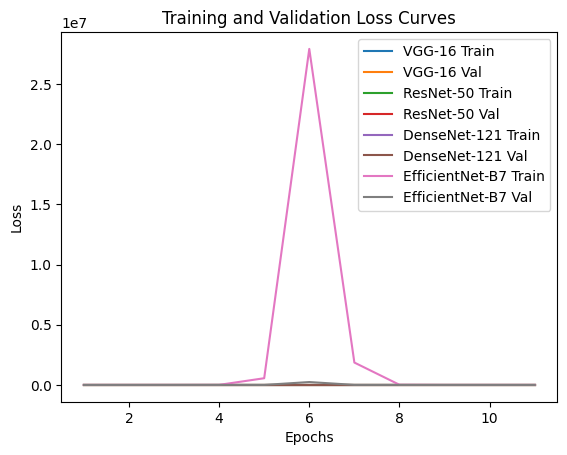

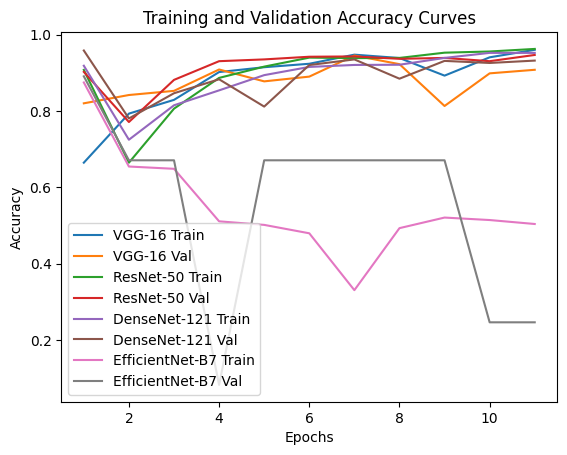

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from efficientnet_pytorch import EfficientNet
import warnings
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

num_epochs = 11

warnings.filterwarnings("ignore")

# Check if GPU is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Custom CNN model
class CustomCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(CustomCNN, self).__init__()

# Load pre-trained models
vgg16 = models.vgg16(pretrained=True)
resnet50 = models.resnet50(pretrained=True)
densenet121 = models.densenet121(pretrained=True)
efficientnet = EfficientNet.from_pretrained('efficientnet-b7')

# ...

# Define the number of classes in your dataset
num_classes = 3

# Modify the last fully connected layer of the pre-trained models
vgg16.classifier[6] = nn.Linear(4096, num_classes)
resnet50.fc = nn.Linear(2048, num_classes)
densenet121.classifier = nn.Linear(1024, num_classes)
efficientnet._fc = nn.Linear(2560, num_classes)

# Define the optimizer and loss function
optimizer_vgg = optim.Adam(vgg16.parameters(), lr=0.001)
optimizer_resnet = optim.Adam(resnet50.parameters(), lr=0.001)
optimizer_densenet = optim.Adam(densenet121.parameters(), lr=0.001)
optimizer_efficientnet = optim.Adam(efficientnet.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Define empty dictionaries to store the metrics
vgg16_history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
resnet50_history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
densenet121_history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
efficientnet_history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

# Training loop for VGG-16
vgg16.to(device)
vgg16.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer_vgg.zero_grad()
        outputs = vgg16(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_vgg.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total
    vgg16_history["train_loss"].append(epoch_loss)
    vgg16_history["train_acc"].append(epoch_acc)
    print(f"VGG-16 - Epoch {epoch + 1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}")

    # Validation
    vgg16.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = vgg16(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        epoch_loss = running_loss / len(val_loader)
        epoch_acc = correct / total
        vgg16_history["val_loss"].append(epoch_loss)
        vgg16_history["val_acc"].append(epoch_acc)
        print(f"VGG-16 - Epoch {epoch + 1}/{num_epochs}, Val Loss: {epoch_loss:.4f}, Val Acc: {epoch_acc:.4f}")


# Training loop for ResNet-50
resnet50.to(device)
resnet50.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer_resnet.zero_grad()
        outputs = resnet50(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_resnet.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total
    resnet50_history["train_loss"].append(epoch_loss)
    resnet50_history["train_acc"].append(epoch_acc)
    print(f"ResNet-50 - Epoch {epoch + 1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}")

    # Validation
    resnet50.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = resnet50(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        epoch_loss = running_loss / len(val_loader)
        epoch_acc = correct / total
        resnet50_history["val_loss"].append(epoch_loss)
        resnet50_history["val_acc"].append(epoch_acc)
        print(f"ResNet-50 - Epoch {epoch + 1}/{num_epochs}, Val Loss: {epoch_loss:.4f}, Val Acc: {epoch_acc:.4f}")

# Training loop for DenseNet-121
densenet121.to(device)
densenet121.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer_densenet.zero_grad()
        outputs = densenet121(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_densenet.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total
    densenet121_history["train_loss"].append(epoch_loss)
    densenet121_history["train_acc"].append(epoch_acc)
    print(f"DenseNet-121 - Epoch {epoch + 1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}")

    # Validation
    densenet121.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = densenet121(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        epoch_loss = running_loss / len(val_loader)
        epoch_acc = correct / total
        densenet121_history["val_loss"].append(epoch_loss)
        densenet121_history["val_acc"].append(epoch_acc)
        print(f"DenseNet-121 - Epoch {epoch + 1}/{num_epochs}, Val Loss: {epoch_loss:.4f}, Val Acc: {epoch_acc:.4f}")

# Training loop for EfficientNet-B7
efficientnet.to(device)
efficientnet.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer_efficientnet.zero_grad()
        outputs = efficientnet(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_efficientnet.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total
    efficientnet_history["train_loss"].append(epoch_loss)
    efficientnet_history["train_acc"].append(epoch_acc)
    print(f"EfficientNet-B7 - Epoch {epoch + 1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}")

    # Validation
    efficientnet.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = efficientnet(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        epoch_loss = running_loss / len(val_loader)
        epoch_acc = correct / total
        efficientnet_history["val_loss"].append(epoch_loss)
        efficientnet_history["val_acc"].append(epoch_acc)
        print(f"EfficientNet-B7 - Epoch {epoch + 1}/{num_epochs}, Val Loss: {epoch_loss:.4f}, Val Acc: {epoch_acc:.4f}")

# Plotting the loss curves
plt.plot(range(1, num_epochs + 1), vgg16_history["train_loss"], label='VGG-16 Train')
plt.plot(range(1, num_epochs + 1), vgg16_history["val_loss"], label='VGG-16 Val')
plt.plot(range(1, num_epochs + 1), resnet50_history["train_loss"], label='ResNet-50 Train')
plt.plot(range(1, num_epochs + 1), resnet50_history["val_loss"], label='ResNet-50 Val')
plt.plot(range(1, num_epochs + 1), densenet121_history["train_loss"], label='DenseNet-121 Train')
plt.plot(range(1, num_epochs + 1), densenet121_history["val_loss"], label='DenseNet-121 Val')
plt.plot(range(1, num_epochs + 1), efficientnet_history["train_loss"], label='EfficientNet-B7 Train')
plt.plot(range(1, num_epochs + 1), efficientnet_history["val_loss"], label='EfficientNet-B7 Val')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.savefig('/content/drive/MyDrive/Mani Thesis/Results_Graphs/CNN/Without_GAN/Dataset1/'+ str('CNN_DCGAN_500+Dataset3_Training and Validation Loss of VGG,Resnet,EfficientNet: Image_Size: ')+str(image_size)+str(' Epoch_No:')+(str(num_epochs)+'.png'))
plt.show()

# Plotting the accuracy curves
plt.plot(range(1, num_epochs + 1), vgg16_history["train_acc"], label='VGG-16 Train')
plt.plot(range(1, num_epochs + 1), vgg16_history["val_acc"], label='VGG-16 Val')
plt.plot(range(1, num_epochs + 1), resnet50_history["train_acc"], label='ResNet-50 Train')
plt.plot(range(1, num_epochs + 1), resnet50_history["val_acc"], label='ResNet-50 Val')
plt.plot(range(1, num_epochs + 1), densenet121_history["train_acc"], label='DenseNet-121 Train')
plt.plot(range(1, num_epochs + 1), densenet121_history["val_acc"], label='DenseNet-121 Val')
plt.plot(range(1, num_epochs + 1), efficientnet_history["train_acc"], label='EfficientNet-B7 Train')
plt.plot(range(1, num_epochs + 1), efficientnet_history["val_acc"], label='EfficientNet-B7 Val')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Curves')
plt.legend()
plt.savefig('/content/drive/MyDrive/Mani Thesis/Results_Graphs/CNN/Without_GAN/Dataset1/'+ str('CNN_DCGAN_500+Dataset3_Training and Validation Accuracy of VGG,Resnet,EfficientNet: Image_Size: ')+str(image_size)+str(' Epoch_No:')+(str(num_epochs)+'.png'))
plt.show()


In [ ]:
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
import torch
import torch.nn as nn
import torchvision.models as models
from efficientnet_pytorch import EfficientNet

# Load the pre-trained weights for EfficientNet-B7
efficientnet_b7 = EfficientNet.from_pretrained('efficientnet-b7')
efficientnet_b7 = efficientnet_b7.to(device)

# Set the models to evaluation mode
vgg16.eval()
resnet50.eval()
densenet121.eval()
efficientnet_b7.eval()

# Initialize lists to store the predictions and true labels
vgg16_preds = []
resnet50_preds = []
densenet121_preds = []
efficientnet_b7_preds = []
true_labels = []

# Iterate over the test dataset and collect the predictions and true labels
for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)

    vgg16_outputs = vgg16(images)
    resnet50_outputs = resnet50(images)
    densenet121_outputs = densenet121(images)
    efficientnet_b7_outputs = efficientnet_b7(images)

    # Apply softmax to the outputs to obtain class probabilities
    vgg16_probs = torch.softmax(vgg16_outputs, dim=1)
    resnet50_probs = torch.softmax(resnet50_outputs, dim=1)
    densenet121_probs = torch.softmax(densenet121_outputs, dim=1)
    efficientnet_b7_probs = torch.softmax(efficientnet_b7_outputs, dim=1)

    # Get the predicted class indices with the highest probability
    _, vgg16_predicted = torch.max(vgg16_probs, 1)
    _, resnet50_predicted = torch.max(resnet50_probs, 1)
    _, densenet121_predicted = torch.max(densenet121_probs, 1)
    _, efficientnet_b7_predicted = torch.max(efficientnet_b7_probs, 1)

    vgg16_preds.extend(vgg16_predicted.cpu().numpy())
    resnet50_preds.extend(resnet50_predicted.cpu().numpy())
    densenet121_preds.extend(densenet121_predicted.cpu().numpy())
    efficientnet_b7_preds.extend(efficientnet_b7_predicted.cpu().numpy())
    true_labels.extend(labels.cpu().numpy())

# Create a confusion matrix for each model
vgg16_cm = confusion_matrix(true_labels, vgg16_preds)
resnet50_cm = confusion_matrix(true_labels, resnet50_preds)
densenet121_cm = confusion_matrix(true_labels, densenet121_preds)
efficientnet_b7_cm = confusion_matrix(true_labels, efficientnet_b7_preds)

# Calculate classification report for each model
vgg16_cr = classification_report(true_labels, vgg16_preds)
resnet50_cr = classification_report(true_labels, resnet50_preds)
densenet121_cr = classification_report(true_labels, densenet121_preds)
efficientnet_b7_cr = classification_report(true_labels, efficientnet_b7_preds)

# Create a DataFrame to store the results
results_df = pd.DataFrame({
    'Class': ['COVID-19', 'Pneumonia', 'Normal', 'COVID-19', 'Pneumonia', 'Normal', 'COVID-19', 'Pneumonia', 'Normal', 'COVID-19', 'Pneumonia', 'Normal'],
    'Model': ['VGG-16', 'VGG-16', 'VGG-16', 'ResNet-50', 'ResNet-50', 'ResNet-50', 'DenseNet-121', 'DenseNet-121', 'DenseNet-121', 'EfficientNet-B7', 'EfficientNet-B7', 'EfficientNet-B7'],
    'Confusion Matrix': [vgg16_cm, vgg16_cm, vgg16_cm, resnet50_cm, resnet50_cm, resnet50_cm, densenet121_cm, densenet121_cm, densenet121_cm, efficientnet_b7_cm, efficientnet_b7_cm, efficientnet_b7_cm],
    'Classification Report': [vgg16_cr, vgg16_cr, vgg16_cr, resnet50_cr, resnet50_cr, resnet50_cr, densenet121_cr, densenet121_cr, densenet121_cr, efficientnet_b7_cr, efficientnet_b7_cr, efficientnet_b7_cr]
})

# Save the DataFrame to an Excel file
results_df.to_excel('/content/drive/MyDrive/Mani Thesis/Results_Graphs/CNN/Without_GAN/Dataset1/'+ str('CNN_DCGAN_500+Dataset3_CNN_VGG_Resnet_Densenet_EfficientNet_Result: Image_Size: ') + str (image_size) +str(' Epoch_No:') + (str(num_epochs)+'.xlsx'))


Loaded pretrained weights for efficientnet-b7
